In [ ]:
!pip install timm --quiet
!pip install scikit-learn --quiet
!pip install -U albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 14.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import numpy as np
from torchvision import transforms
import torch

source_root = "/kaggle/input/emotion-dataset"
cleaned_root = "/kaggle/working/dataset_cleaned"

if os.path.exists(cleaned_root):
    shutil.rmtree(cleaned_root)
os.makedirs(cleaned_root)

In [ ]:
all_files = []
class_names_list = sorted([d for d in os.listdir(source_root) if os.path.isdir(os.path.join(source_root, d))])
class_to_idx = {name: i for i, name in enumerate(class_names_list)}
idx_to_class = {i: name for i, name in enumerate(class_names_list)}

for class_name in class_names_list:
    class_dir = os.path.join(source_root, class_name)
    class_idx = class_to_idx[class_name]
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_files.append((os.path.join(class_dir, fname), class_idx))

print(f"Found {len(all_files)} images across {len(class_names_list)} classes.")


Found 58304 images across 5 classes.


In [ ]:
image_paths, labels = zip(*all_files)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
resize_transform = transforms.Resize((224, 224))

def process_and_copy_files(paths, labels, split_name):
    print(f"Processing {split_name} set...")
    for path, label in zip(paths, labels):
        class_name = idx_to_class[label]
        dst_dir = os.path.join(cleaned_root, split_name, class_name)
        os.makedirs(dst_dir, exist_ok=True)

        try:
            img = Image.open(path).convert("RGB")
            img = resize_transform(img)
            img.save(os.path.join(dst_dir, os.path.basename(path)))
        except Exception as e:
            print(f"  - Skipping: {path} ({e})")

process_and_copy_files(train_paths, train_labels, "Train")
process_and_copy_files(val_paths, val_labels, "Val")

print("Done. Cleaned dataset at:", cleaned_root)


Processing Train set...
  - Skipping: /kaggle/input/emotion-dataset/happy/happy1283.jpg (cannot identify image file '/kaggle/input/emotion-dataset/happy/happy1283.jpg')

Processing Val set...

Done. Cleaned dataset at: /kaggle/working/dataset_cleaned


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision import datasets
import cv2

In [ ]:
train_dir = "/kaggle/working/dataset_cleaned/Train"
val_dir = "/kaggle/working/dataset_cleaned/Val"

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),

    A.Affine(
        scale=(0.85, 1.15),
        translate_percent=0.08,
        rotate=(-30, 30),
        p=0.7
    ),

    A.GridDistortion(p=0.3),
    A.ElasticTransform(alpha=120, sigma=6, p=0.3),

    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
        A.HueSaturationValue(p=1.0),
    ], p=0.8),

    A.ToGray(p=0.1),
    A.GaussianBlur(p=0.2),
    A.GaussNoise(p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
class AlbumentationsDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=None)
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, target

train_dataset = AlbumentationsDataset(train_dir, transform=train_transform)
val_dataset = AlbumentationsDataset(val_dir, transform=val_transform)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Found {num_classes} classes: {class_names}")

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Using Albumentations-based DataLoaders with strong training augmentations.")

Found 5 classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']

 Using Albumentations-based DataLoaders with strong training augmentations.


In [ ]:
import timm
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm.loss import LabelSmoothingCrossEntropy
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 10
learning_rate = 1e-4
weight_decay = 0.1
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(train_dataset.classes)
model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=True,
    num_classes=num_classes
)
model.to(device)

criterion = LabelSmoothingCrossEntropy(smoothing=0.15)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
scaler = GradScaler()

train_loss_values = []
val_loss_values = []
val_acc_values = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    scheduler.step()
    train_acc = 100. * correct / total
    epoch_train_loss = running_train_loss / total
    train_loss_values.append(epoch_train_loss)

    print(f" Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, Accuracy = {train_acc:.2f}%")

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    epoch_val_loss = running_val_loss / total
    val_loss_values.append(epoch_val_loss)
    val_acc_values.append(val_acc)

    print(f" Validation: Loss = {epoch_val_loss:.4f}, Accuracy = {val_acc:.2f}%\n")

Using device: cuda


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

[Epoch 1/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=62.4, loss=1.15]

 Epoch 1: Train Loss = 1.1499, Accuracy = 62.36%


 Validation: Loss = 0.9840, Accuracy = 73.64%



[Epoch 2/10] Training: 100%|██████████| 365/365 [13:58<00:00,  2.30s/it, acc=71.9, loss=0.947]

 Epoch 2: Train Loss = 1.0061, Accuracy = 71.89%


 Validation: Loss = 0.9185, Accuracy = 77.39%



[Epoch 3/10] Training: 100%|██████████| 365/365 [13:58<00:00,  2.30s/it, acc=75.8, loss=0.809]

 Epoch 3: Train Loss = 0.9456, Accuracy = 75.79%


 Validation: Loss = 0.9090, Accuracy = 77.83%



[Epoch 4/10] Training: 100%|██████████| 365/365 [13:58<00:00,  2.30s/it, acc=79.3, loss=0.915]

 Epoch 4: Train Loss = 0.8927, Accuracy = 79.32%


 Validation: Loss = 0.8536, Accuracy = 82.11%



[Epoch 5/10] Training: 100%|██████████| 365/365 [13:58<00:00,  2.30s/it, acc=82.4, loss=0.911]

 Epoch 5: Train Loss = 0.8431, Accuracy = 82.41%


 Validation: Loss = 0.8177, Accuracy = 83.84%



[Epoch 6/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=85.4, loss=0.849]

 Epoch 6: Train Loss = 0.7954, Accuracy = 85.39%


 Validation: Loss = 0.7860, Accuracy = 86.55%



[Epoch 7/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=88, loss=0.808]

 Epoch 7: Train Loss = 0.7532, Accuracy = 88.05%


 Validation: Loss = 0.7609, Accuracy = 88.15%



[Epoch 8/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=90, loss=0.655]

 Epoch 8: Train Loss = 0.7210, Accuracy = 89.98%


 Validation: Loss = 0.7436, Accuracy = 89.29%



[Epoch 9/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=91.3, loss=0.675]

 Epoch 9: Train Loss = 0.7011, Accuracy = 91.30%


 Validation: Loss = 0.7356, Accuracy = 89.84%



[Epoch 10/10] Training: 100%|██████████| 365/365 [14:00<00:00,  2.30s/it, acc=91.9, loss=0.646]

 Epoch 10: Train Loss = 0.6908, Accuracy = 91.92%


 Validation: Loss = 0.7305, Accuracy = 90.09%



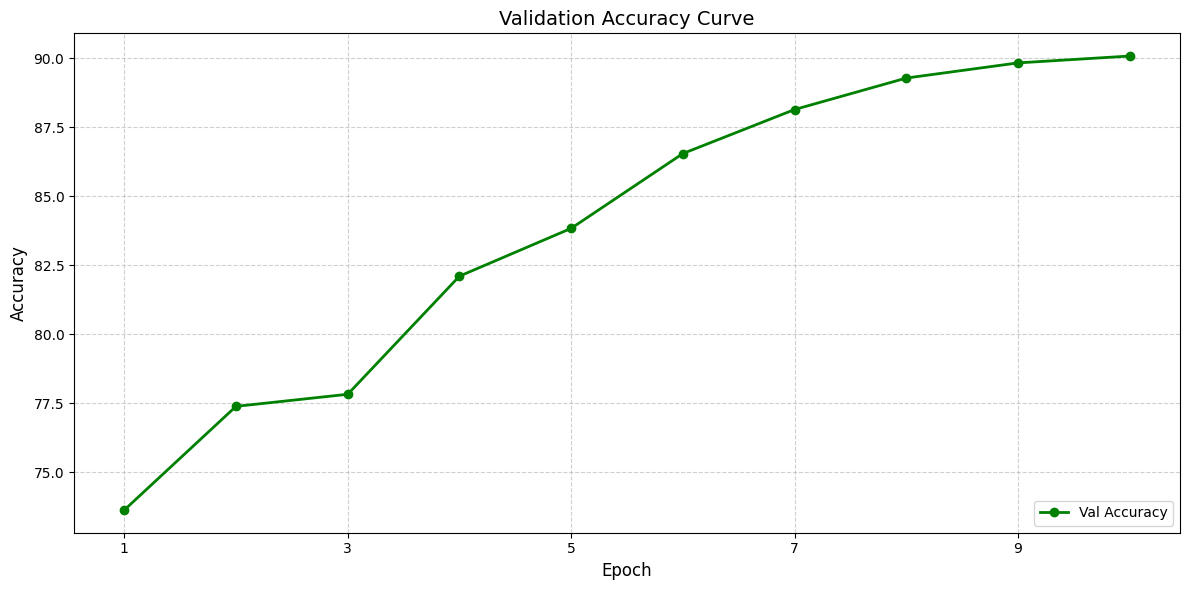

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(val_acc_values, label='Val Accuracy', linewidth=2, marker='o', color='green')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(0, num_epochs, step=2), np.arange(1, num_epochs + 1, step=2))
plt.tight_layout()
plt.show()

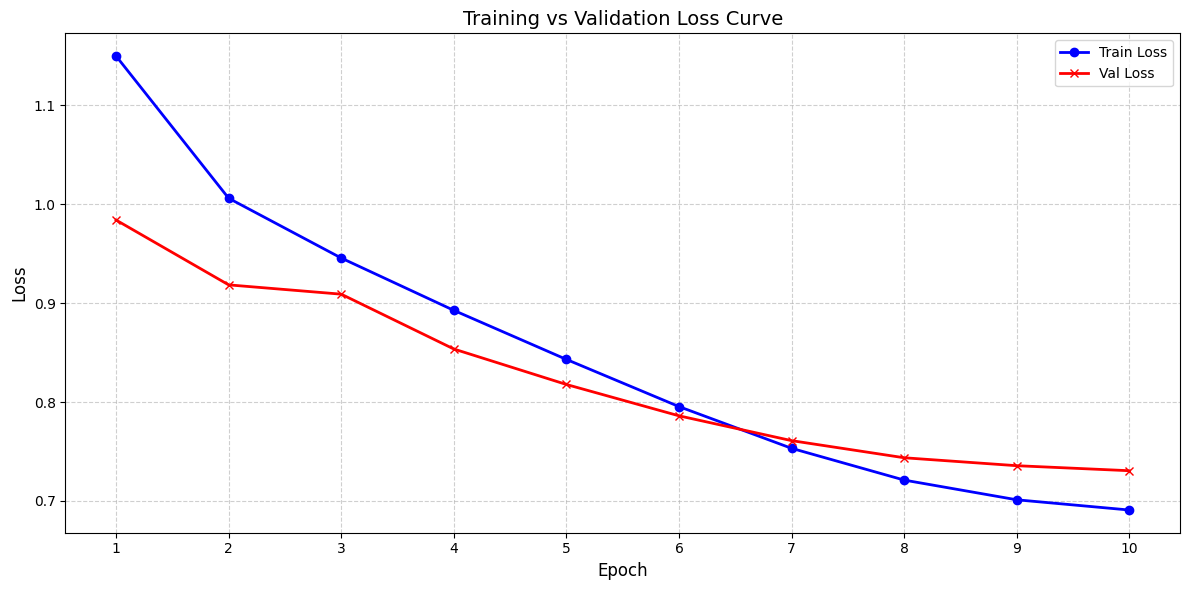

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Train Loss', linewidth=2, marker='o', color='blue')
plt.plot(val_loss_values, label='Val Loss', linewidth=2, marker='x', color='red')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss Curve", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(0, num_epochs), np.arange(1, num_epochs + 1))
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

Class Names: ['angry', 'happy', 'neutral', 'sad', 'surprise']


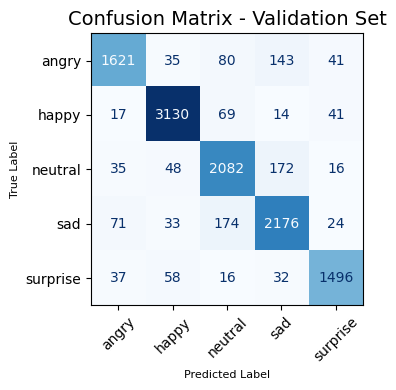

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []

model_save_path = "best_model.pth"
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Class Names: {class_names}")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(
    ax=ax,
    cmap=plt.cm.Blues,
    xticks_rotation=45,
    values_format='d',
    colorbar=False
)
plt.title("Confusion Matrix - Validation Set", fontsize=14)
plt.xlabel("Predicted Label", fontsize=8)
plt.ylabel("True Label", fontsize=8)
plt.tight_layout()
plt.show()


 Using device: cuda
 Predicted Class: angry (75.57%)


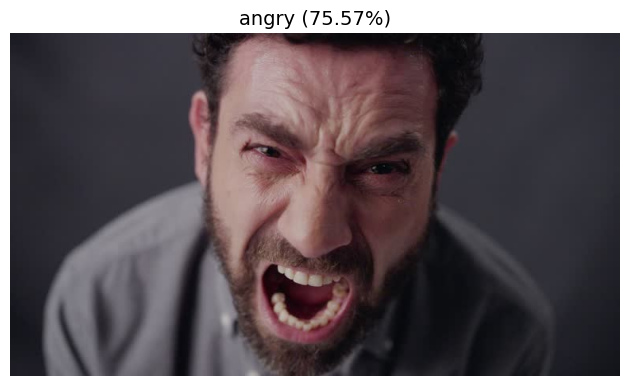


 Multi-Class Probabilities:
angry               : 75.57%
happy               : 2.13%
neutral             : 7.84%
sad                 : 6.25%
surprise            : 8.21%


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

class_names = train_dataset.classes

image_path = "/kaggle/input/proper-test/test/angry/angry-1.jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=False,
    num_classes=len(class_names)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1).squeeze()
    confidence, predicted_idx = torch.max(probs, dim=0)
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

print(f" Predicted Class: {predicted_class} ({confidence_percent:.2f}%)")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence_percent:.2f}%)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Multi-Class Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:<20}: {prob.item() * 100:.2f}%")

 Using device: cuda
 Predicted Class: surprise (54.85%)


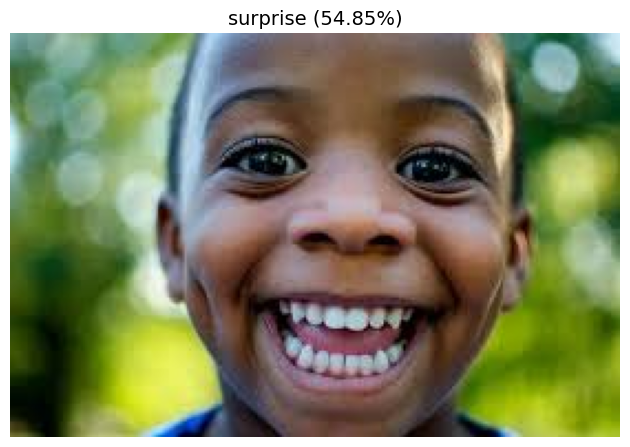


 Multi-Class Probabilities:
angry               : 4.93%
happy               : 24.27%
neutral             : 9.40%
sad                 : 6.56%
surprise            : 54.85%


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

class_names = train_dataset.classes

image_path = "/kaggle/input/proper-test/test/happy/happy-1.jpeg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=False,
    num_classes=len(class_names)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1).squeeze()
    confidence, predicted_idx = torch.max(probs, dim=0)
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

print(f" Predicted Class: {predicted_class} ({confidence_percent:.2f}%)")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence_percent:.2f}%)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Multi-Class Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:<20}: {prob.item() * 100:.2f}%")


 Using device: cuda
 Predicted Class: neutral (71.12%)


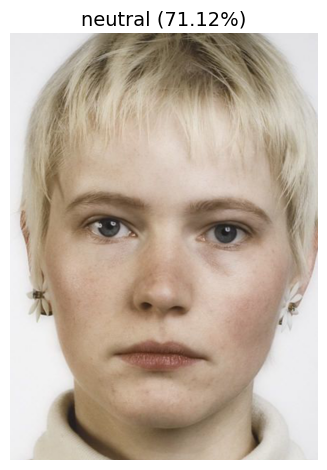


 Multi-Class Probabilities:
angry               : 6.29%
happy               : 3.40%
neutral             : 71.12%
sad                 : 13.38%
surprise            : 5.80%


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

class_names = train_dataset.classes

image_path = "/kaggle/input/proper-test/test/neutral/neutral-2.png"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=False,
    num_classes=len(class_names)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1).squeeze()
    confidence, predicted_idx = torch.max(probs, dim=0)
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

print(f" Predicted Class: {predicted_class} ({confidence_percent:.2f}%)")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence_percent:.2f}%)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Multi-Class Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:<20}: {prob.item() * 100:.2f}%")

 Using device: cuda
 Predicted Class: sad (93.20%)


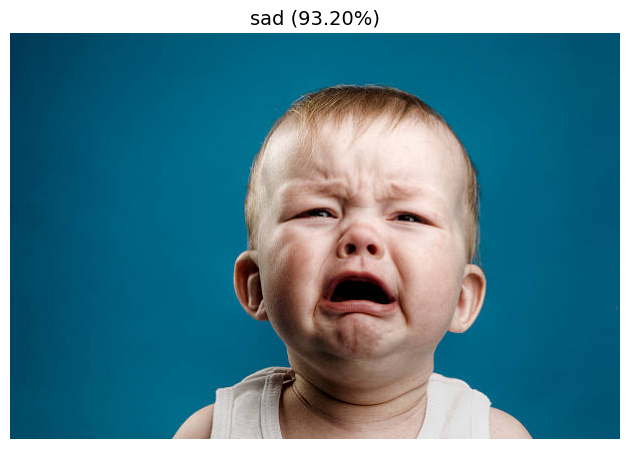


 Multi-Class Probabilities:
angry               : 3.43%
happy               : 0.86%
neutral             : 0.96%
sad                 : 93.20%
surprise            : 1.54%


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

class_names = train_dataset.classes

image_path = "/kaggle/input/proper-test/test/sad/sad-2.jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=False,
    num_classes=len(class_names)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1).squeeze()
    confidence, predicted_idx = torch.max(probs, dim=0)
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

print(f" Predicted Class: {predicted_class} ({confidence_percent:.2f}%)")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence_percent:.2f}%)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Multi-Class Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:<20}: {prob.item() * 100:.2f}%")

 Using device: cuda
 Predicted Class: surprise (90.03%)


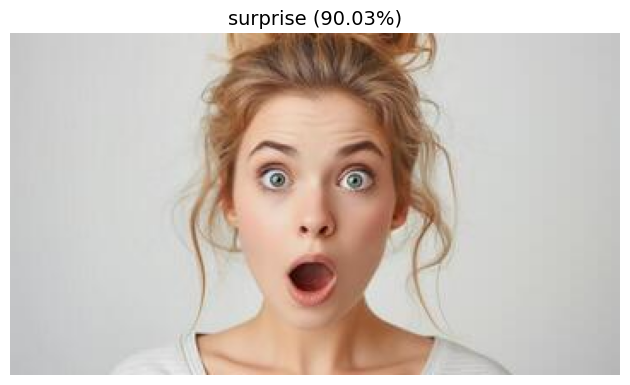


 Multi-Class Probabilities:
angry               : 3.94%
happy               : 1.65%
neutral             : 2.52%
sad                 : 1.87%
surprise            : 90.03%


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

class_names = train_dataset.classes

image_path = "/kaggle/input/proper-test/test/surpise/surprise-1.jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

model = timm.create_model(
    "convnextv2_tiny.fcmae_ft_in1k",
    pretrained=False,
    num_classes=len(class_names)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1).squeeze()
    confidence, predicted_idx = torch.max(probs, dim=0)
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

print(f" Predicted Class: {predicted_class} ({confidence_percent:.2f}%)")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence_percent:.2f}%)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Multi-Class Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]:<20}: {prob.item() * 100:.2f}%")